In [1]:
# Import required packages

import os
import warnings
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation, LSTM, Embedding, SimpleRNN
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences

In [2]:
# Getting file path
file_name = "Final_News_DF_Labeled_ExamDataset.csv"
dir_path = os.path.dirname(os.path.realpath("__file__"))
path = os.path.join(dir_path, file_name)

In [3]:
# Opening data
news_df = pd.read_csv(path)

# Turning data into arrays
X = np.array(news_df.drop('LABEL', axis=1))

y = news_df.LABEL

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalizing X data 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Making a train/test split of the arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
# ANN Implementation

# Create early stopping to minimize run time
early_stops = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=10, restore_best_weights=True)

# Creating the sequential model
model = Sequential()

# Adding a dense layer for the input vector to connect to with 16 hidden units
model.add(Dense(16, input_shape = (300,), activation='relu'))
model.add(Dropout(0.2))
16
# Adding a dense layer for the last vector to connect to with 16 hidden units
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Creating the final layer with 3 options for the 3 numbers available, 
# using softmax activation to come up with likelihoods for each number
model.add(Dense(3, activation='softmax'))

# Compiling the model with the sparse categorical crossentropy loss function to allow for more than one answer
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Fitting the model to our training data
history = model.fit(X_train, y_train, epochs=500, batch_size=30, callbacks=[early_stops], verbose=0)

# Printing final structure of the model
# print("Final structure of the model")
# print(model.summary())

# Creating a dataframe to store the accuracy and loss over time
history_df = pd.DataFrame(history.history)

# This model only gets to about 73% accuracy on the testing data, but after a lot of trial and error that was the best I could manage


In [5]:
# Getting the test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

In [6]:
# Creating confusion matrix
predictions = model.predict([X_test], verbose=0)

final_predictions = np.squeeze(np.array(predictions.argmax(axis=1)))

cm = confusion_matrix(y_test, final_predictions)

In [7]:
# CNN

# Modify X data to be a 2D array
X_train_cnn, X_test_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Modify the y data to one hot
y_train_cnn = keras.utils.to_categorical(y_train)
y_test_cnn = keras.utils.to_categorical(y_test)

In [8]:

# Create a CNN classifier

CNN_model = Sequential()

# Adding a 1D convolutional layer, with a filter kernal size of 5x1, and 128 filters
CNN_model.add(Conv1D(128, 5, activation='relu', input_shape=(300, 1)))

# Add a MaxPooling layer
CNN_model.add(MaxPooling1D(3))

# Adding a 1D convolutional layer, with a filter kernal size of 3x1, and 64 filters
CNN_model.add(Conv1D(64, 3, activation='relu'))

# Adding a drop out layer
CNN_model.add(Dropout(0.2))
CNN_model.add(Flatten())
# Adding the final softmax classified
CNN_model.add(Dense(3, activation='softmax'))

# Compile the model
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_cnn = CNN_model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=30, callbacks=[early_stops], verbose=0)

history_df_cnn = pd.DataFrame(history_cnn.history)

In [9]:
# Evaluate the model on the test set
loss_cnn, accuracy_cnn = CNN_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

In [10]:
# Create the confusion matrix
predictions_cnn = CNN_model.predict([X_test_cnn], verbose=0)

y_true_cnn = np.squeeze(np.array(y_test_cnn.argmax(axis=1)))

final_predictions_cnn = np.squeeze(np.array(predictions_cnn.argmax(axis=1)))

cm_cnn = confusion_matrix(y_true_cnn, final_predictions_cnn)

In [11]:
# LSTM

# One hot encoded data
y_train_LSTM, y_test_LSTM = y_train_cnn, y_test_cnn
X_train_LSTM, X_test_LSTM = X_train_cnn, X_test_cnn

LSTM_model = Sequential()

# Adding an LSTM layer with 50 hidden units that returns a sequence
LSTM_model.add(LSTM(units=64, input_shape=(300, 1), return_sequences=True))

# Adding an LSTM layer with 10 hidden units
LSTM_model.add(LSTM(units=32))

# Adding a dropout layer to avoid overfitting
LSTM_model.add(Dropout(0.1))

# Adding a final dense layer to classify the output
LSTM_model.add(Dense(3, activation='softmax'))
# Compile the model
LSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

# Train the model
history_lstm = LSTM_model.fit(X_train, y_train_LSTM, epochs=100, batch_size=30, verbose=0)

history_df_lstm = pd.DataFrame(history_lstm.history)

In [12]:
# Evaluate the model on the test set
loss_lstm, accuracy_lstm = LSTM_model.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)

In [13]:
# Create the confusion matrix
predictions_lstm = LSTM_model.predict([X_test_LSTM], verbose=0)

y_true_lstm = np.squeeze(np.array(y_test_LSTM.argmax(axis=1)))

final_predictions_lstm = np.squeeze(np.array(predictions_lstm.argmax(axis=1)))

cm_lstm = confusion_matrix(y_true_lstm, final_predictions_lstm)

In [14]:
x_unique = np.unique(np.array(news_df.drop('LABEL', axis=1)))
x_unique_scale = np.unique(X)
loss_df = pd.DataFrame({'ANN':test_loss, 'CNN':loss_cnn, 'LSTM':loss_lstm}, index=[0])
accuracy_df = pd.DataFrame({'ANN':test_accuracy, 'CNN':accuracy_cnn, 'LSTM':accuracy_lstm}, index=[0])
effeciency_df = pd.DataFrame({'ANN':1.6, 'CNN':8.1, 'LSTM':308}, index=[0])

# Nathan Korinek Final: ANN, CNN, and LSTM comparison

The final question of the exam asked me to build an ANN, CNN, and LSTM network in order to run a classification task on data that described news articles by noting how many of 300 common words were in each article. 

## Data Cleanup

The first thing I had to do was prepare the data. For this, I made the array with the word counts from all the data that wasn't the label. I then made the correct output array from the labeled column. For the ANN, I simply encoded the data as either 0, 1, or 2, where football is 0, science is 1, and politics is 2. For the CNN and LSTM, I used one hot encoding to make the data more suitable for those networks, meaning football is [0, 0, 1], science is [0, 1, 0], and politics is [1, 0, 0]. This is more suitable for these networks due to the shapes of the data being used and how compatible they are with the network


In [15]:
print("Original y data example: {}, {}, {}".format(news_df.LABEL[0], news_df.LABEL[501], news_df.LABEL[1002]))
print("Y data modified for ANN example: {}, {}, {}".format(y[0], y[501], y[1002]))
print("Y data modified for CNN/LSTM example: {}, {}, {}".format(y_train_cnn[0], y_train_cnn[200], y_train_cnn[1100]))

Original y data example: politics, football, science
Y data modified for ANN example: 1, 0, 2
Y data modified for CNN/LSTM example: [0. 1. 0.], [0. 1. 0.], [0. 0. 1.]



I used a scalar to modify the word count data, making it turn from 0, 1, 2, 3, 4 to values between 0 and 1. 

I then split the data into training and testing data, both the words data and the correct output data. I used an 80/20 split, where 80 percent of the data is used to train each model, and the remaining 20 percent of data is left out to test the model on. 

In [16]:
print("Original values for X data: {}".format(x_unique))
print("Scaled values for X data: {}".format(list(x_unique_scale)))

Original values for X data: [0 1 2 3 4]
Scaled values for X data: [0.0, 0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0]


In [17]:
print("Original word data shape: {}".format(X.shape))
print("Original correct labels data shape: {}".format(y.shape))

print("\nTraining word data shape: {}".format(X_test.shape))
print("Training correct labels data shape: {}".format(y_test.shape))

print("\nTesting word data shape: {}".format(X_train.shape))
print("Testing correct labels data shape: {}".format(y_train.shape))

print("\nCNN/LSTM Training word data shape: {}".format(X_test_cnn.shape))
print("CNN/LSTM Training correct labels data shape: {}".format(y_test_cnn.shape))

print("\nCNN/LSTM Testing word data shape: {}".format(X_train_cnn.shape))
print("CNN/LSTM Testing correct labels data shape: {}".format(y_train_cnn.shape))

Original word data shape: (1493, 300)
Original correct labels data shape: (1493,)

Training word data shape: (299, 300)
Training correct labels data shape: (299,)

Testing word data shape: (1194, 300)
Testing correct labels data shape: (1194,)

CNN/LSTM Training word data shape: (299, 300, 1)
CNN/LSTM Training correct labels data shape: (299, 3)

CNN/LSTM Testing word data shape: (1194, 300, 1)
CNN/LSTM Testing correct labels data shape: (1194, 3)



## ANN Coding

For the ANN, I made a fairly simple dense model. There are two hidden layers with 16 units each. Each layer has a dropout layer with a value of .2 after it. The final layer is a softmax dense layer, with 3 outputs, to match the 3 categories our data can fall into. This was the best architecture I came up with after much trial and error. I ran this model for 500 epochs with an early stopping function. The early stopping told the model to stop training if there wasn't an improvement in the model's accuracy over 10 epochs. 

# CNN Coding

The CNN model I made was more complex. I had to further modify the data, adding a "dimension" of 1 to the word count data in order to make it 3D. The CNN model needs the data to be at least 3 dimensional for the training to work. After this, I created a model. The first layer was a 1D convolutional layer with a filter size of 5. This layer applied a filter to the input data every 5 columns, and went 5 columns at a time with that filter in order to get the modified output. After this, I used a Max Pooling layer with a fily_true_lstmter size of 3. This is similar to the 1d convolutional layer, except that the Max Pooling takes the highest value of the 3 values it looks at and assigns it to the cell it's on. After the max pooling, I had one more convolutional layer with a filter size of three, before adding a drop out layer with a value of .2, and a flattening layer in order to make the data more understandable to the final softmax layer in the model. 

## LSTM Coding

Putting the data into an LSTM was difficult. Normally an LSTM would be well suited to this sort of data, as it does well with sequential data. However, since this data did not store any of the sequential data of the original text, I had to make the model pretend they were sequences with temporal dependency. I created one LSTM layer with 64 hidden units, and had it return sequential data in order to have a second LSTM layer with 32 hidden units that did not return sequential data. I added one drop out layer before applying the softmax function to the output in order to get the final predictions. 

## Comparing the models

### Accuracy

#### Training

Below you can see the models accuracies as they trained over hundreds of epochs. The ANN trained quickly and became familiar with the training data. I had the model set up to run for 500 epochs but if the model didn't improve it's accuracy for 10 epochs in a row then it was told to stop, so it generally stops before 100 epochs. The CNN had a very similar pattern for the training accuracy, and also stopped earlier than the alloted epochs. As you can see the LSTM struggled much more, training in a bumpy and less straightforward way, and not getting up to a very high accuracy. It ran for all 100 epochs that I asked it to. 

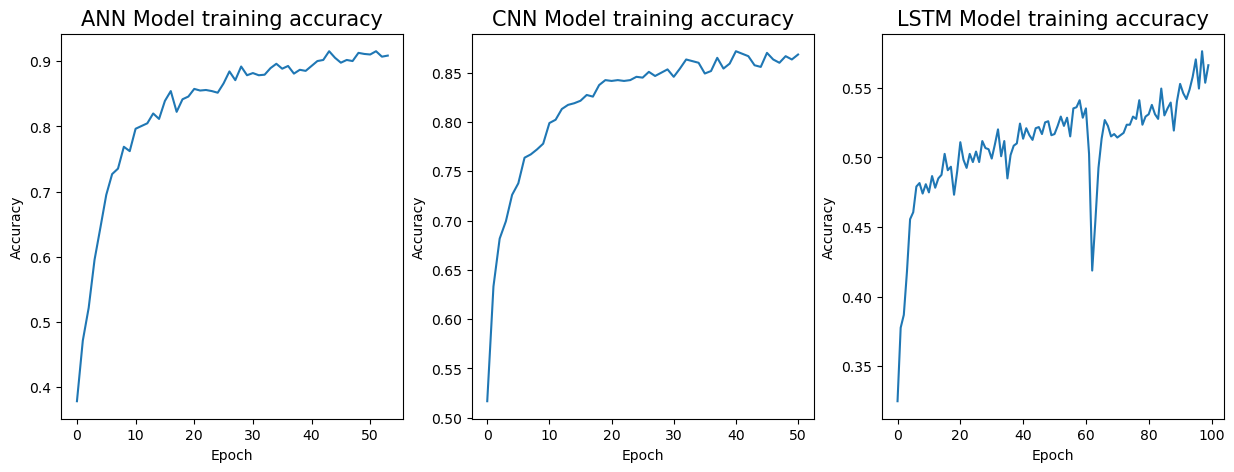

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

# Plotting training accuracy for ANN
ax1.plot(history.history['accuracy'])
ax1.set_title('ANN Model training accuracy', size=15)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

# Plotting training accuracy for CNN
ax2.plot(history_cnn.history['accuracy'])
ax2.set_title('CNN Model training accuracy', size=15)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')

# Plotting training accuracy for LSTM
ax3.plot(history_lstm.history['accuracy'])
ax3.set_title('LSTM Model training accuracy', size=15)
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epoch')
plt.show()


#### Testing

The patterns here are fairly similar to the training data. The testing data saw similar accuracy for the ANN and CNN, around 70% accuracy. This isn't as high as I would have liked, but I could not figure out how to fine tune the models in a way to get higher testing accuracy. I added drop out layers and reduced complexity but these were the highest values I was able to produce. The LSTM however was noteably worse, hovering around 50% accuracy. 

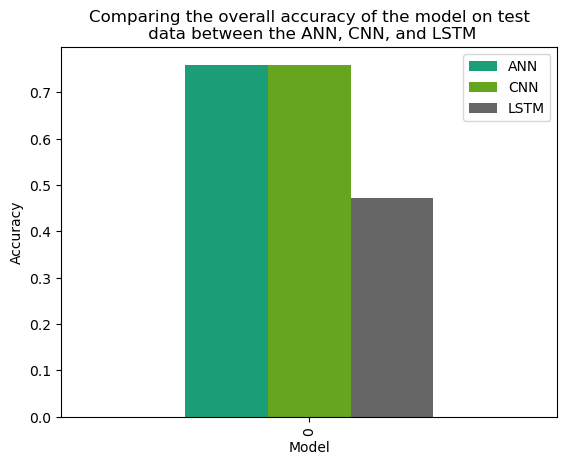

In [19]:
# Plot testing accuracy comparisons

fig, ax = plt.subplots()
accuracy_df.plot.bar(ax=ax, cmap='Dark2')
ax.set(title="Comparing the overall accuracy of the model on test\n data between the ANN, CNN, and LSTM", xlabel="Model", ylabel="Accuracy")
plt.show()


### Loss

#### Training

The models loss has very similar patterns to the training data but inversed, as the lower the loss the better the model is. The ANN and CNN have similar shapes, learning quickly and smoothly, while the LSTM struggled and never had a smooth easy learning path. 

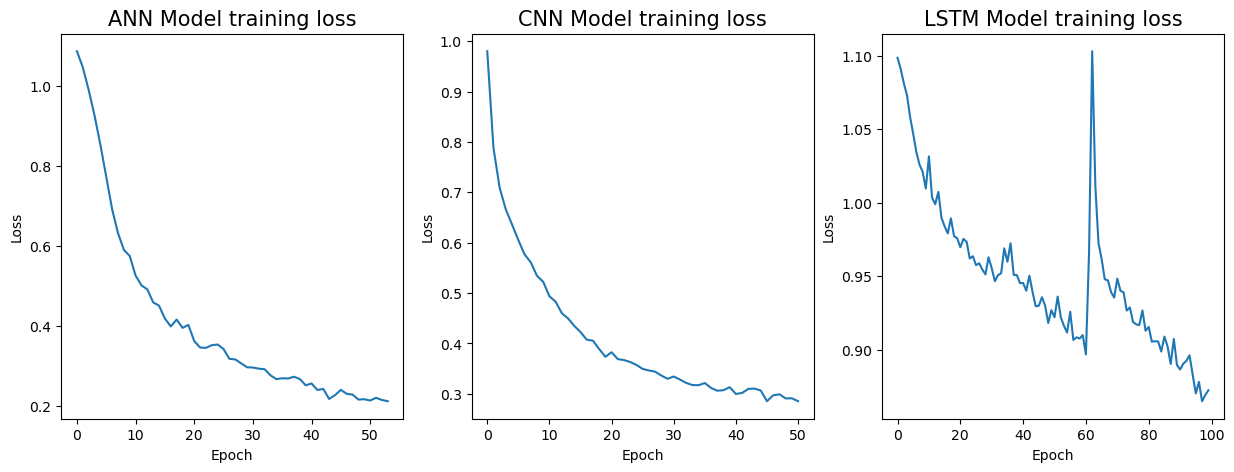

In [20]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

# Plotting training loss for ANN
ax1.plot(history.history['loss'])
ax1.set_title('ANN Model training loss', size=15)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

# Plotting training loss for CNN
ax2.plot(history_cnn.history['loss'])
ax2.set_title('CNN Model training loss', size=15)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

# Plotting training loss of LSTM
ax3.plot(history_lstm.history['loss'])
ax3.set_title('LSTM Model training loss', size=15)
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
plt.show()


#### Testing

The testing data for the loss comparisons shows a slightly more interesting pattern. This shows overall loss, where the LSTM had the highest overall loss, and the ANN has the lowest. 

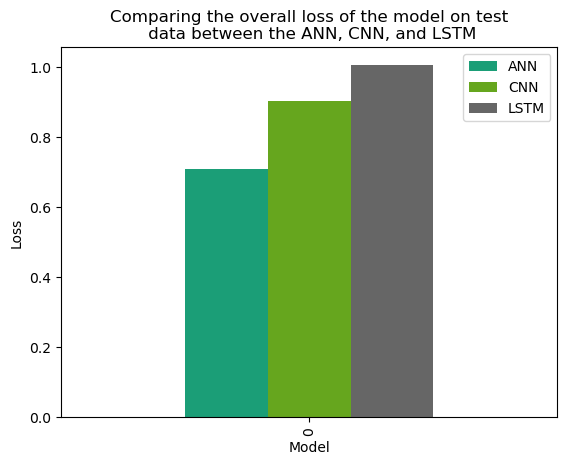

In [21]:
# Plot testing loss comparisons

fig, ax = plt.subplots()
loss_df.plot.bar(ax=ax, cmap='Dark2')
ax.set(title="Comparing the overall loss of the model on test\n data between the ANN, CNN, and LSTM", xlabel="Model", ylabel="Loss")
plt.show()

### Confusion Matrices

Here we can see the confusion matrices for the models, how they labeled the testing data compared to the correct answers. The ANN and CNN are shockingly similar. They both had the most issues comparing politics and science articles, which makes sense due to the nature of the topics covered. The LSTM was all over the place, it seemed to label data as science with too high of a rate, and struggled very much to identify football and politics articles. 

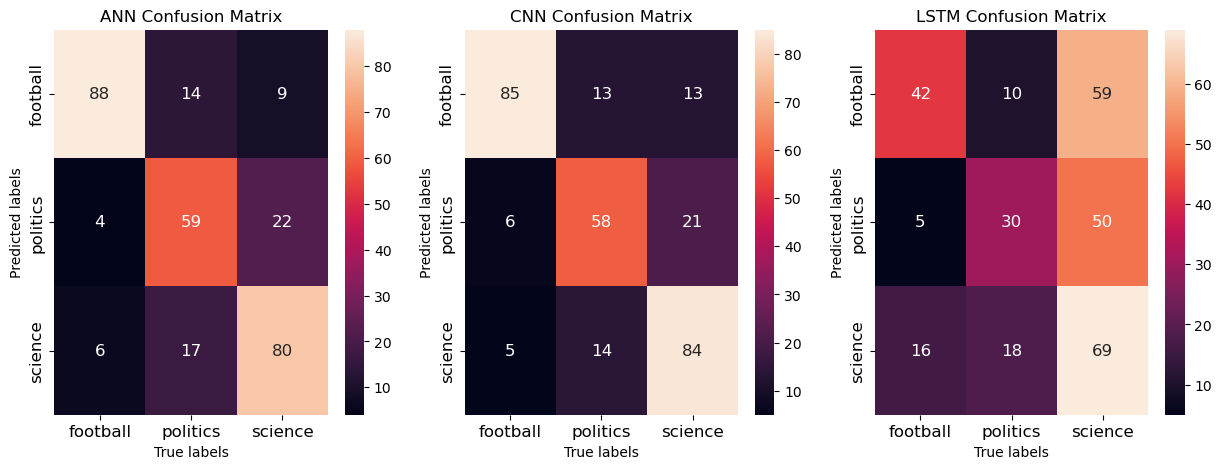

In [22]:

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

# ANN Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', ax=ax1, annot_kws={'size': 12})

vals = ['football', 'politics', 'science']

ax1.set_xlabel('True labels') 
ax1.set_ylabel('Predicted labels')
ax1.set_title('ANN Confusion Matrix') 
ax1.xaxis.set_ticklabels(vals, fontsize = 12)

ax1.yaxis.set_ticklabels(vals, fontsize = 12)

# CNN Confusion matrix
sns.heatmap(cm_cnn, annot=True, fmt='g', ax=ax2, annot_kws={'size': 12})

ax2.set_xlabel('True labels') 
ax2.set_ylabel('Predicted labels')
ax2.set_title('CNN Confusion Matrix') 
ax2.xaxis.set_ticklabels(vals, fontsize = 12)

ax2.yaxis.set_ticklabels(vals, fontsize = 12)

# LSTM Confusion matrix
sns.heatmap(cm_lstm, annot=True, fmt='g', ax=ax3, annot_kws={'size': 12})

ax3.set_xlabel('True labels') 
ax3.set_ylabel('Predicted labels')
ax3.set_title('LSTM Confusion Matrix') 
ax3.xaxis.set_ticklabels(vals, fontsize = 12)

ax3.yaxis.set_ticklabels(vals, fontsize = 12)

plt.show()

### Effeciency

The models varied greatly in how effecient they were. The ANN was the quickest model by far, running around 60 epochs in 1.6 seconds. The CNN was slightly less effecient, running around 60 epochs in 8.1 seconds. The LSTM was by far the least effecient model, running 100 epochs in 5 minutes and 8 seconds. This is the expected pattern based on the network architectures. 

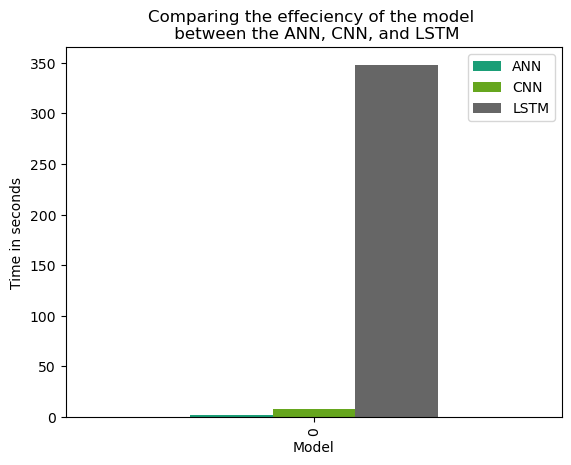

In [23]:
# Plot effeciency comparisons

fig, ax = plt.subplots()
effeciency_df.plot.bar(ax=ax, cmap='Dark2')
ax.set(title="Comparing the effeciency of the model \n between the ANN, CNN, and LSTM", xlabel="Model", ylabel="Time in seconds")
plt.show()

## Final Comparisons and Thoughts

None of the models became as accurate as I was hoping, and there could be a few explanations. It could be that my archictectures were not well built, however I did much trial and error with each so I have doubts that that is the entire issue. I believe that if there was more data, my models may have seen greater accuracy. 

The ANN seemed like it was well equipped to handle this data. I did not have to do much work preparing the data for the ANN, and it ran quickly with relatively good results. 

The CNN was slightly less equipped for this data. I had to spoof it to make the model think it was 3D data even though it wasn't, giving it a third dimension of 1. CNN's are built for image data more than this vector data. However, once that was set up, the CNN ran well. It was slower than the ANN, but ended up being just as accurate. 

The LSTM was the worst model both in accuracy and effeciency. LSTM's are generally models that are built for temporal and sequential data, where the order of the data matters. This is normally great for word based data. However, due to how we recieved the data, there was no way to add temporality or know the original sequence of the words. Due to this I had to pretend that the data was sequential even when it isn't, and the recurrent nature of the LSTM did not deal with that well. 

If I just had the news articles, the LSTM would be the obvious choice for this type of data. However, since I recieved it in the format of straight word counts, the ANN was the best solution for this data, running quickly and relatively well. 